In [1]:
import torch
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from analytical_models.gde_co import System, InputParameters
from analytical_models import gde_co

In [2]:
args = dict(
    T=298, 
    p0=1, 
    Q=30, # liquid flow rate , ml/min 
    flow_chan_length=0.02, 
    flow_chan_height=5e-3, 
    flow_chan_width=1.5e-3, 
    L=20e-6, 
    eps=0.9, 
    r=(25+50)/2 * 1e-9, # 25 - 50 nm 
    c_khco3=500, 
    c_k=500, 
    dic=10**-3.408, 
    method='CO2 eql'
)
ipt = InputParameters(**args)
S = System(ipt, mod=np)
r1 = S.solve(-0.7)

def dict_to_torch(d):
    out = {}
    for k, v in d.items():
        try:
            out[k] = torch.tensor(v)
        except TypeError:
            out[k] = v
    return out

ipt = InputParameters(**dict_to_torch(args))
dc = dict_to_torch(S.diffusion_coefficients)
se = dict_to_torch(S.salting_out_exponents)
erc = dict_to_torch(S.electrode_reaction_kinetics)
crr = dict_to_torch(S.chemical_reaction_rates)
S = System(ipt, diffusion_coefficients=dc, salting_out_exponents=se, electrode_reaction_kinetics=erc, chemical_reaction_rates=crr, mod=torch)
r2 = S.solve(torch.tensor([-0.7]))

for k in r1.keys():
    assert np.allclose(r1[k], r2[k].item(), rtol=1e-3, atol=1e-3)

In [3]:
def make_numpy_system():
    _ipt = InputParameters(**args)
    return System(_ipt, mod=np)
def make_torch_system():
    _ipt = InputParameters(**dict_to_torch(args))
    _dc = dict_to_torch(gde_co.diffusion_coefficients)
    _se = dict_to_torch(gde_co.salting_out_exponents)
    _erc = dict_to_torch(gde_co.electrode_reaction_kinetics)
    _crr = dict_to_torch(gde_co.chemical_reaction_rates)
    return System(_ipt, diffusion_coefficients=_dc, salting_out_exponents=_se, electrode_reaction_kinetics=_erc, chemical_reaction_rates=_crr, mod=torch)

In [4]:
S = make_numpy_system()
%timeit S.solve(-0.4)
%timeit S.solve_current(200)

1.46 ms ± 59.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3.96 ms ± 110 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
S = make_torch_system()
%timeit S.solve(-0.4)
%timeit S.solve_current(200)

9.52 ms ± 90.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.9 ms ± 95.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Why does it take so long to solve with the torch system?

In [82]:
S = make_torch_system()
%timeit S.solve(-0.4)

17 ms ± 446 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
# is it better to do minimization or root solving?
def minimize(self: System, target_current_density, voltage_bounds=(-1, 0), return_residual=False):
    V = target_current_density.item() if isinstance(target_current_density, torch.Tensor) else target_current_density
    if self.mod is torch:
        S = self.copy(keep_grad=False)
    else:
        S = self
    f = lambda phi: (S.solve(phi)['current_density'] - V)**2
    res = optimize.minimize_scalar(f, bounds=voltage_bounds)
    if not res.success:
        print(res.message)
    phi = res.x
    residuals = res.fun
    # found operating point. Now do forward pass with original model
    out = self.solve(phi)
    if return_residual:
        return out, residuals
    return out

def root(self: System, target_current_density, voltage_bounds=(-1, 0)):
    V = target_current_density.item() if isinstance(target_current_density, torch.Tensor) else target_current_density
    if self.mod is torch:
        S = self.copy(keep_grad=False)
    else:
        S = self
    f = lambda phi: S.solve(phi)['current_density'] - V
    phi, res = optimize.brentq(f, *voltage_bounds, full_output=True)
    if not res.converged:
        print(res.flag)
    # found operating point. Now do forward pass with original model
    out = self.solve(phi)
    return out

In [50]:
S = make_numpy_system()
%timeit minimize(S, 200)
%timeit root(S, 200)

24.8 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Both methods are nearly identical!

In [77]:
# how about manually implementing a solution with vectorized operation?
def interp_root(self: System, target_current_density, voltage_bounds=(-1, 0), grid_size=500, interp_method='linear'):
    V = target_current_density.item() if isinstance(target_current_density, torch.Tensor) else target_current_density
    if self.mod is torch:
        S = self.copy(keep_grad=False)
    else:
        S = self
    phi = np.linspace(*sorted(voltage_bounds, reverse=True), grid_size)
    I = S.solve(phi)['current_density']
    if interp_method == 'linear':
        phi = np.interp(V, I, phi)
    elif interp_method == 'manual':
        i0 = np.searchsorted(I, V) - 1
        i1 = i0 + 1
        phi0 = phi[i0]
        phi1 = phi[i1]
        I0 = I[i0]
        I1 = I[i1]
        phi = phi0 + (V - I0) * (phi1 - phi0) / (I1 - I0)
    elif interp_method == 'quadratic':
        i0 = np.searchsorted(I, V) - 2
        p = np.polyfit(I[i0:i0+3], phi[i0:i0+3], 2)
        phi = np.polyval(p, V)
    elif interp_method == 'cubic':
        i0 = np.searchsorted(I, V) - 2
        p = np.polyfit(I[i0:i0+3], phi[i0:i0+3], 3)
        phi = np.polyval(p, V)
    else:
        raise ValueError(f'Unknown interp_method: {interp_method}')
    # we are solving it twice anyways! 
    out = self.solve(phi)
    return out

def interp_2stage(self: System, target_current_density, voltage_bounds=(-1, 0), grid_size=500):
    V = target_current_density.item() if isinstance(target_current_density, torch.Tensor) else target_current_density
    if self.mod is torch:
        S = self.copy(keep_grad=False)
    else:
        S = self
    phi = np.linspace(*sorted(voltage_bounds, reverse=True), grid_size) # monotonic decreasing
    I = S.solve(phi)['current_density'] # monotonic increasing
    # look up using searchsorted
    idx = np.searchsorted(I, V)
    phi = np.linspace(phi[idx-1], phi[idx], grid_size)
    I = S.solve(phi)['current_density']
    phi = np.interp(V, I, phi)
    out = self.solve(phi)
    return out

def interp_grid(self: System, target_current_density, voltage_bounds=(-1, 0), grid_size=500):
    V = target_current_density.item() if isinstance(target_current_density, torch.Tensor) else target_current_density
    if self.mod is torch:
        S = self.copy(keep_grad=False)
    else:
        S = self
    phi = np.linspace(*sorted(voltage_bounds, reverse=True), grid_size)
    I = S.solve(phi)['current_density']
    idx = np.searchsorted(I, V) - 1
    phi = np.linspace(phi[idx], phi[idx+1], grid_size)
    # now solve again and pick the closest one
    res = self.solve(phi)
    idx = np.argmin(np.abs(res['current_density'] - V))
    out = {}
    for k, v in res.items():
        out[k] = v[idx]
    return out

In [78]:
S = make_numpy_system()
target = 200
%timeit interp_root(S, target)
res = interp_root(S, target)['current_density'] - target
print(res)
%timeit interp_root(S, target, interp_method='manual')
res = interp_root(S, target)['current_density'] - target
print(res)
%timeit interp_root(S, target, interp_method='quadratic')
res = interp_root(S, target)['current_density'] - target
print(res)
%timeit interp_2stage(S, target)
res = interp_2stage(S, target)['current_density'] - target
print(res)
%timeit interp_grid(S, target)
res = interp_grid(S, target)['current_density'] - target
print(res) # small improvement in accuracy

3.92 ms ± 156 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-0.004159917851950468
3.99 ms ± 249 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-0.004159917851950468
3.99 ms ± 220 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-0.004159917851950468
5.99 ms ± 187 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-2.6591862933855737e-08
4.36 ms ± 212 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
0.0031864255057030277


Conclusion: no improvement in residual when using cubic interpolation as opposed to linear!

In [55]:
# what is the vectorization saving?
%timeit S.solve(-0.4)
%timeit S.solve(np.linspace(-1.0, 0.0, 10))
%timeit S.solve(np.linspace(-1.0, 0.0, 100))
%timeit S.solve(np.linspace(-1.0, 0.0, 1000))

1.77 ms ± 50.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.96 ms ± 34.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2 ms ± 53.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.52 ms ± 231 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
%timeit S.solve(np.linspace(-1.0, 0.0, 1000))

2.47 ms ± 165 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


It makes more sense to do 10x finer grid as opposed to doing 2 searches

Compare the residual for the two methods

This is working fine!

In [7]:
S.input_parameters.L.requires_grad = True
res, residuals = S.solve_current(200, return_residual=True)
res['fe'].backward()
print(S.input_parameters.L.grad)

tensor(-11799.0967)


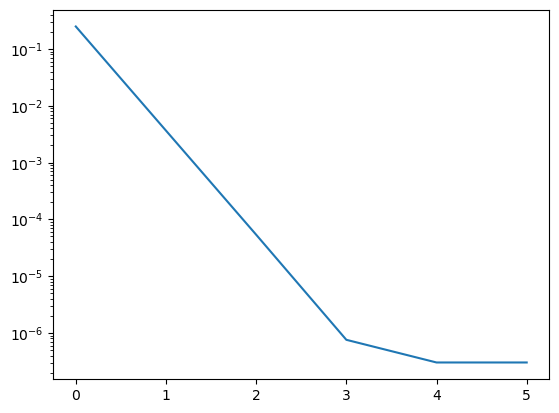

In [4]:
plt.plot(residuals)
plt.yscale('log')

Solve current also appears to be working fine

In [5]:
res['current_density']

tensor(199.9995, grad_fn=<AddBackward0>)